<a href="https://colab.research.google.com/github/Akhilesh-K-Yadav/NMA-22-DL-Saltenas-Project/blob/main/Saltenas2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports
import os, requests
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp
import gzip
import plotnine as p9

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from tqdm.auto import tqdm
from IPython.display import display

from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

DEVICE = 'cuda'

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
mice = np.unique(pd.DataFrame(np.array(os.listdir('/content/drive/MyDrive/Mouse_Data/')))[0].apply(lambda x: x[0:15]))
print(mice)

vip_mouse_id = [467951, 467953, 467954, 489066, 492395]
sst_mouse_id = [470784, 476970, 477202, 480753, 485688, 489056, 498972]
slc_mouse_id = [461946, 462468, 462544, 464204, 464207]

['Slc_mouse461946' 'Slc_mouse462468' 'Slc_mouse462544' 'Slc_mouse464204'
 'Slc_mouse464207' 'Sst_mouse470784' 'Sst_mouse476970' 'Sst_mouse477202'
 'Sst_mouse480753' 'Sst_mouse485688' 'Sst_mouse489056' 'Sst_mouse498972'
 'Vip_mouse467951' 'Vip_mouse467953' 'Vip_mouse467954' 'Vip_mouse489066'
 'Vip_mouse492395' 'accuracy_data_N']


In [ ]:
cell_count_data = pd.DataFrame({'area':np.repeat(['Slc','Sst','Vip'],[5,7,5]),
              'mouse':np.concatenate((slc_mouse_id,sst_mouse_id,vip_mouse_id)),
              'cell_count':[288,653,376,401,232,25,31,19,8,26,18,15,22,43,17,24,75]})

In [ ]:
# Function to load in data from mounted drive on Colab
def load_gzip_arrays(fn, dir = '/content/drive/MyDrive/Mouse_Data/'):
    f = gzip.GzipFile(dir+fn+'_label.npy.gz', "r")
    label_data = np.load(f,allow_pickle=True)
    label_data = pd.DataFrame(label_data,columns=['image_name','is_change','omitted','session_number'])

    f = gzip.GzipFile(dir+fn+'_dffbc.npy.gz', "r")
    dff_bc = np.load(f)

    f = gzip.GzipFile(dir+fn+'_dffstim.npy.gz', "r")
    dff_stim = np.load(f)

    f = gzip.GzipFile(dir+fn+'_dffts.npy.gz', "r")
    dff_ts = np.load(f)

    return label_data, dff_bc, dff_stim, dff_ts

In [ ]:
# Prepare input data
def prepare_data(dff_mat, label_data, trial_subset, cell_subset = [], cell_limit = np.Inf, y_name = 'image_name'):
  if len(dff_mat.shape)==3:
    X = dff_mat[trial_subset,:,:].squeeze()
    if len(cell_subset)==0:
      cell_sum_activities = np.nansum(X.astype('float64'),axis=(0,2))
      cell_subset = np.flatnonzero(cell_sum_activities)
    X = X[:,cell_subset,:]

    if cell_limit<len(cell_subset):
      cell_mean_variance = np.nanmean(X.var(axis=2),axis=0)
      most_variable_cells = cell_mean_variance.argsort()[:cell_limit]
      #most_variable_cells = np.random.choice(X.shape[1],cell_limit,replace=False)
      X = X[:,most_variable_cells,:]
      cell_subset = cell_subset[most_variable_cells]
    
    X = np.nan_to_num(X)
    y = label_data.loc[trial_subset,y_name]
    _, y = np.unique(y, return_inverse=True)

  elif len(dff_mat.shape)==2:
    X = dff_mat[trial_subset,:].squeeze()
    if len(cell_subset)==0:
      cell_sum_activities = X.sum(axis=0)
      cell_subset = np.flatnonzero(cell_sum_activities)
    X = X[:,cell_subset]

    if cell_limit<len(cell_subset):
      cell_variance = X.var(axis=0)
      most_variable_cells = cell_variance.argsort()[:cell_limit]
      X = X[:,most_variable_cells]
      cell_subset = cell_subset[most_variable_cells]

    X = np.nan_to_num(X)
    y = label_data.loc[trial_subset,y_name]
    _, y = np.unique(y, return_inverse=True)

  else:
    print('Error: dff_mat must be 2D or 3D')

  return X, y, cell_subset

In [ ]:
# fn = f'{area}_mouse{mouse_id}'
# label_data, dff_bc, dff_stim, dff_ts = load_gzip_arrays(fn)

# # Possible subsetting groups
# not_omitted = np.logical_not(label_data['omitted'])
# familiar = label_data['session_number']<=3
# novel = label_data['session_number']>3
# passive = np.logical_or(label_data['session_number']==2, label_data['session_number']==5)
# active = np.logical_not(passive)
# is_change = label_data['is_change']
# not_change = np.logical_not(is_change)

# # Choose train/test and out-of-distribution subsets
# subset = np.where(np.logical_and.reduce([not_change, not_omitted, familiar]))
# subset2 = np.where(np.logical_and.reduce([is_change, not_omitted, familiar]))

# dff_mat = dff_ts
# trial_subset = subset[0]
# cell_subset=[]
# cell_limit=75

# X = dff_mat[trial_subset,:,:].squeeze()
# if len(cell_subset)==0:
#   cell_sum_activities = np.nansum(X.astype('float64'),axis=(0,2))
#   cell_subset = np.flatnonzero(cell_sum_activities)
# X = X[:,cell_subset,:]

# if cell_limit<len(cell_subset):
#   cell_mean_variance = np.nanmean(X.var(axis=2),axis=0)
#   most_variable_cells = cell_mean_variance.argsort()[:cell_limit]
#   #most_variable_cells = np.random.choice(X.shape[1],cell_limit,replace=False)
#   X = X[:,most_variable_cells,:]
#   cell_subset = cell_subset[most_variable_cells]

# X = np.nan_to_num(X)
# y = label_data.loc[trial_subset,'image_name']
# _, y = np.unique(y, return_inverse=True)

# Prepare data (CHOOSE DATASET HERE)
# X, y, cell_subset = prepare_data(dff_ts, label_data, subset[0], cell_subset = [], cell_limit = 75) # Limit is same as Vip mouse with most cels
# X_out, y_out, _ = prepare_data(dff_ts, label_data, subset2[0], cell_subset)

# # Create train/test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, stratify=y)

In [ ]:
class NetDropout(nn.Module):
  """
  Network Class - 2D with the following structure:
  nn.Linear(1, 300) + leaky_relu(self.dropout1(self.fc1(x))) # First fully connected layer with 0.4 dropout
  nn.Linear(300, 500) + leaky_relu(self.dropout2(self.fc2(x))) # Second fully connected layer with 0.2 dropout
  nn.Linear(500, 1) # Final fully connected layer
  """

  def __init__(self,input_feature_num, target_dim = 8):
    super(NetDropout, self).__init__()
    self.fc1 = nn.Linear(input_feature_num, 100)
    self.fc2 = nn.Linear(100, 100)
    self.fc3 = nn.Linear(100, target_dim)
    #self.dropout1 = nn.Dropout(0.5)
    #self.dropout2 = nn.Dropout(0.2)

  def forward(self, x):
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    #x = F.leaky_relu(self.dropout1(self.fc3(x)))
    #x = F.leaky_relu(self.dropout1(self.fc4(x)))
    output = self.fc3(x)
    return output

In [ ]:
class ConvNetNarrow(nn.Module):
  " Conv net wiht variable number of layers and widths"
  def __init__(self,input_feature_num, wPool=[12, 6], wLinear=25, target_dim = 8):
    super(ConvNetNarrow, self).__init__()
    filters_num = 1
    self.Conv = nn.Sequential()
    for nLayer, wp in enumerate(wPool):
      self.Conv.add_module(f'conv_{nLayer}', nn.Conv1d(input_feature_num,filters_num*input_feature_num,kernel_size=5,padding=2,stride=1))
      self.Conv.add_module(f'pool_{nLayer}', nn.AdaptiveAvgPool1d(wp))
    
    # self.conv1 = nn.Conv1d(input_feature_num,filters_num*input_feature_num,kernel_size=5,padding=2,stride=1)
    # self.conv2 = nn.Conv1d(filters_num*input_feature_num,filters_num*input_feature_num,kernel_size=5,padding=2,stride=1)
    # self.conv3 = nn.Conv1d(filters_num*input_feature_num,filters_num*input_feature_num,kernel_size=5,padding=2,stride=1)
    # self.pool = nn.AdaptiveAvgPool1d(12)
    # self.pool2 = nn.AdaptiveAvgPool1d(6)
    self.fc1 = nn.Linear(filters_num*input_feature_num*wPool[-1], wLinear)
    self.fc2 = nn.Linear(wLinear, target_dim)

  def forward(self, x):
    x0 = self.Conv(x)
    x1 = x0.reshape(x0.shape[0],x0.shape[1]*x0.shape[2])
    x2 = F.leaky_relu(self.fc1(x1))
    output = self.fc2(x2)
    return output


In [ ]:
def fit_one_mouse(area, mouse_id, n_train_epochs, y_name = 'image_name', method='MLP', cnnpools=[6], cnnlinearwidth=25):
  fn = f'{area}_mouse{mouse_id}'
  print('--------------\n'+fn)
  label_data, dff_bc, dff_stim, dff_ts = load_gzip_arrays(fn)
  print(f'Number of imaged cells: {dff_bc.shape[1]}')

  # Possible subsetting groups
  not_omitted = np.logical_not(label_data['omitted'])
  familiar = label_data['session_number']<=3
  novel = label_data['session_number']>3
  passive = np.logical_or(label_data['session_number']==2, label_data['session_number']==5)
  active = np.logical_not(passive)
  is_change = label_data['is_change']
  not_change = np.logical_not(is_change)
  follow_change = np.logical_and(np.roll(is_change,2), not_change)

  if y_name=='image_name':
    target_dim = 8
    y_type = torch.int64
    criterion = nn.CrossEntropyLoss()
    # Choose train/test and out-of-distribution subsets
    subset = np.where(np.logical_and.reduce([not_change, not_omitted, familiar]))
    subset2 = np.where(np.logical_and.reduce([is_change, not_omitted, familiar]))
  elif y_name=='is_change':
    target_dim = 1
    y_type = torch.float64
    criterion = nn.BCEWithLogitsLoss()
    subset = np.where(np.logical_and.reduce([active, not_omitted, familiar, np.logical_or(is_change,follow_change)]))
    subset2 = np.where(np.logical_and.reduce([passive, not_omitted, familiar, np.logical_or(is_change,follow_change)]))

  # Prepare data (CHOOSE DATASET HERE)
  X, y, cell_subset = prepare_data(dff_bc, label_data, subset[0], cell_subset = [], cell_limit = np.Inf, y_name = y_name)
  X_out, y_out, _ = prepare_data(dff_bc, label_data, subset2[0], cell_subset, y_name = y_name)

  # Create train/test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, stratify=y, random_state=42)

  if method=='MLP' or method=='CNN':
    X_train = torch.Tensor(X_train).to(DEVICE)
    X_test = torch.Tensor(X_test).to(DEVICE)
    X_out = torch.Tensor(X_out).to(DEVICE)
    y_train = torch.Tensor(y_train).to(y_type).to(DEVICE)
    y_test = torch.Tensor(y_test).to(y_type).to(DEVICE)
    y_out = torch.Tensor(y_out).to(y_type).to(DEVICE)

    # Initialize network
    if method=='MLP':
      net = NetDropout(X_train.shape[1],target_dim).to(DEVICE)
    elif method=='CNN':
      net = ConvNetNarrow(X_train.shape[1],cnnpools,cnnlinearwidth,target_dim).to(DEVICE)

    optimizer = optim.Adam(net.parameters(), weight_decay=1e-4, lr=1e-2)
    #criterion = nn.CrossEntropyLoss()

    training_losses = np.empty(n_train_epochs)
    validation_losses = np.empty(n_train_epochs)
    out_losses = np.empty(n_train_epochs)
    training_accs = np.empty(n_train_epochs)
    validation_accs = np.empty(n_train_epochs)
    out_accs = np.empty(n_train_epochs)

    def yhat_class(yhat):
      if y_name=='image_name':
        _, yhc = torch.max(yhat, 1)
      elif y_name=='is_change':
        yhc = torch.round(torch.sigmoid(yhat))
      return yhc

    net.train()
    for i in tqdm(range(n_train_epochs)):
      optimizer.zero_grad()

      with torch.no_grad():
        yhat_val = net(X_test).to(DEVICE).flatten()
        loss_val = criterion(yhat_val, y_test)

        yhat_out = net(X_out).to(DEVICE).flatten()
        loss_out = criterion(yhat_out, y_out)

      yhat_train = net(X_train).to(DEVICE).flatten()
      loss = criterion(yhat_train, y_train)
      loss.backward()
      optimizer.step()

      with torch.no_grad():
        training_losses[i] = loss.item()
        validation_losses[i] = loss_val.item()
        out_losses[i] = loss_out.item()

        yhat_train_class = yhat_class(yhat_train)
        training_accs[i] = (yhat_train_class == y_train).float().sum()/len(yhat_train_class)

        yhat_val_class = yhat_class(yhat_val)
        validation_accs[i] = (yhat_val_class == y_test).float().sum()/len(yhat_val_class)

        yhat_out_class = yhat_class(yhat_out)
        out_accs[i] = (yhat_out_class == y_out).float().sum()/len(yhat_out_class)

    # Evaluate
    net.eval()

    # plt.figure()
    # plt.title(fn)
    # plt.ylabel('Training Loss')
    # plt.xlabel('Epoch')
    # plt.plot(training_losses,label='train')
    # plt.plot(validation_losses,label='validate')
    # plt.plot(out_losses,label='is_change')
    # plt.legend()

    # plt.figure()
    # plt.title(fn)
    # plt.ylabel('Training Accuracy')
    # plt.xlabel('Epoch')
    # plt.plot(training_accs,label='train')
    # plt.plot(validation_accs,label='validate')
    # plt.plot(out_accs,label='is_change')
    # plt.legend()

    train_acc = np.median(training_accs[:-7])
    test_acc = np.median(validation_accs[:-7])
    out_acc = np.median(out_accs[:-7])

  elif method=='SVM':
    model = SVC(probability=True)
    model.fit(X_train, y_train)
    yhat_train = model.predict(X_train)
    yhat_val = model.predict(X_test)
    yhat_out = model.predict(X_out)

    train_acc = accuracy_score(y_train, yhat_train)
    test_acc = accuracy_score(y_test, yhat_val)
    out_acc = accuracy_score(y_out, yhat_out)

    # cm = confusion_matrix(y_test, yhat_test)
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # disp.plot()
    # plt.show()

  print(f'Training score: {np.round(train_acc,2)}')
  print(f'Test score: {np.round(test_acc,2)}')
  print(f'Out score: {np.round(out_acc,2)}')

  acc_data = pd.DataFrame({'accuracy':[train_acc,test_acc,out_acc],'data':['train','test','out'],'mouse':mouse_id,'area':area,'n_cells':len(cell_subset)})
  if method=='CNN':
    acc_data['num_conv_layers'] = len(cnnpools)
    acc_data['fc_width'] = cnnlinearwidth

  return acc_data

accuracy_data = []
for area, mouse_ids in zip(['Slc','Sst','Vip'],[slc_mouse_id,sst_mouse_id,vip_mouse_id]):
  for mouse_id in mouse_ids:
    n_train_epochs = 500
    mouse_acc_data = fit_one_mouse(area, mouse_id, n_train_epochs, y_name='is_change', method='MLP')
    accuracy_data.append(mouse_acc_data)

accuracy_data = pd.concat(accuracy_data)

--------------
Slc_mouse461946
Number of imaged cells: 288


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 1.0
Test score: 0.76
Out score: 0.53
--------------
Slc_mouse462468
Number of imaged cells: 653


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 1.0
Test score: 0.9
Out score: 0.57
--------------
Slc_mouse462544
Number of imaged cells: 376


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 1.0
Test score: 0.69
Out score: 0.56
--------------
Slc_mouse464204
Number of imaged cells: 401


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 1.0
Test score: 0.81
Out score: 0.56
--------------
Slc_mouse464207
Number of imaged cells: 232


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 1.0
Test score: 0.56
Out score: 0.56
--------------
Sst_mouse470784
Number of imaged cells: 25


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 0.97
Test score: 0.61
Out score: 0.59
--------------
Sst_mouse476970
Number of imaged cells: 31


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 0.95
Test score: 0.67
Out score: 0.59
--------------
Sst_mouse477202
Number of imaged cells: 19


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 0.86
Test score: 0.64
Out score: 0.56
--------------
Sst_mouse480753
Number of imaged cells: 8


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 0.66
Test score: 0.57
Out score: 0.55
--------------
Sst_mouse485688
Number of imaged cells: 26


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 1.0
Test score: 0.75
Out score: 0.58
--------------
Sst_mouse489056
Number of imaged cells: 18


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 0.85
Test score: 0.56
Out score: 0.56
--------------
Sst_mouse498972
Number of imaged cells: 15


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 0.82
Test score: 0.66
Out score: 0.66
--------------
Vip_mouse467951
Number of imaged cells: 22


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 0.99
Test score: 0.56
Out score: 0.52
--------------
Vip_mouse467953
Number of imaged cells: 43


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 1.0
Test score: 0.61
Out score: 0.5
--------------
Vip_mouse467954
Number of imaged cells: 17


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 0.92
Test score: 0.57
Out score: 0.53
--------------
Vip_mouse489066
Number of imaged cells: 24


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 0.99
Test score: 0.6
Out score: 0.49
--------------
Vip_mouse492395
Number of imaged cells: 75


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 1.0
Test score: 0.53
Out score: 0.52


In [ ]:
net.train()
optimizer.zero_grad()

with torch.no_grad():
  yhat_val = net(X_test).to(DEVICE)
  loss_val = criterion(yhat_val, y_test)

  yhat_out = net(X_out).to(DEVICE)
  loss_out = criterion(yhat_out, y_out)

yhat_train = net(X_train).to(DEVICE)
loss = criterion(yhat_train, y_train)
loss.backward()
optimizer.step()

with torch.no_grad():
  training_losses[i] = loss.item()
  validation_losses[i] = loss_val.item()
  out_losses[i] = loss_out.item()

  yhat_train_class = yhat_class(yhat_train)
  training_accs[i] = (yhat_train_class == y_train).float().sum()/len(yhat_train_class)

  yhat_val_class = yhat_class(yhat_val)
  validation_accs[i] = (yhat_val_class == y_test).float().sum()/len(yhat_val_class)

  yhat_out_class = yhat_class(yhat_out)
  out_accs[i] = (yhat_out_class == y_out).float().sum()/len(yhat_out_class)


In [ ]:
# CNN architecture search
accuracy_data = []
for cnnpools in [[6],[12,6]]:
  for cnnlinwid in [20, 30]:
    #for area, mouse_ids in zip(['Slc','Sst','Vip'],[slc_mouse_id,sst_mouse_id,vip_mouse_id]):
    for area, mouse_ids in zip(['Slc','Sst','Vip'],[[slc_mouse_id[0]],[sst_mouse_id[0]],[vip_mouse_id[0]]]):
      for mouse_id in mouse_ids:
        n_train_epochs = 500
        mouse_acc_data = fit_one_mouse(area, mouse_id, n_train_epochs, method='CNN', cnnpools = cnnpools, cnnlinearwidth = cnnlinwid)
        accuracy_data.append(mouse_acc_data)

accuracy_data = pd.concat(accuracy_data)

/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  margin_vars = [list(data.columns & self.rows),
/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  list(data.columns & self.cols)]
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/themes/theme.py:250: MatplotlibDeprecationWarning: 
The datapath rcparam was deprecated in Matplotlib 3.2.1 and will be removed two minor

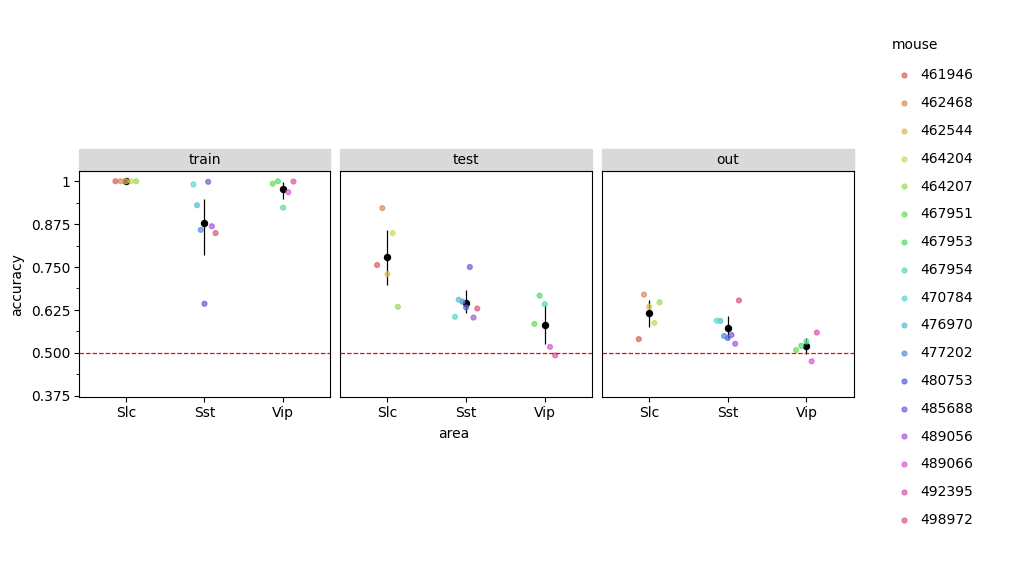

<ggplot: (8756321718509)>


In [ ]:
accuracy_plot(accuracy_data)

In [ ]:
def accuracy_plot(accuracy_data):
  accuracy_data = accuracy_data.astype({'mouse':'category','data':'category','area':'category'})
  accuracy_data['data'] = pd.Categorical(accuracy_data['data'],categories=['train','test','out'])

  print(p9.ggplot(accuracy_data, p9.aes('area','accuracy'))
    + p9.scale_x_discrete()
    + p9.scale_y_continuous(limits=(0.4,1),breaks=np.linspace(0,1,9))
    + p9.facet_grid('. ~ data')
    + p9.stat_summary()
    + p9.geom_point(p9.aes(color='mouse'),position=p9.positions.position_dodge(width=0.33), alpha=0.7)
    + p9.theme_matplotlib()
    + p9.geom_hline(yintercept=0.5,color='red',linetype='dashed')
    + p9.theme(figure_size=(10,3))
    )

In [ ]:
def architecture_plot(accuracy_data):
  catcols = ['mouse','data','area','num_conv_layers']
  accuracy_data[catcols] = accuracy_data[catcols].astype('category')
  accuracy_data['data'] = pd.Categorical(accuracy_data['data'],categories=['train','test','out'])

  print(p9.ggplot(accuracy_data, p9.aes('fc_width','accuracy',color='num_conv_layers'))
    + p9.scale_x_continuous()
    #+ p9.scale_y_continuous(limits=(0,1),breaks=np.linspace(0,1,9))
    + p9.facet_grid('area ~ data',scales='fixed')
    + p9.geom_line()
    + p9.geom_point()
    # + p9.stat_summary(fun_data = 'median_hilow', geom=p9.geoms.geom_pointrange)
    # + p9.stat_summary(fun_data = 'median_hilow', geom=p9.geoms.geom_line)
    #+ p9.geom_point(p9.aes(color='mouse'),position=p9.positions.position_dodge(width=0.33), alpha=0.7)
    + p9.theme_matplotlib()
    + p9.geom_hline(yintercept=0.125,color='red',linetype='dashed')
    + p9.theme(figure_size=(10,6))
    )

/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  margin_vars = [list(data.columns & self.rows),
/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  list(data.columns & self.cols)]
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/themes/theme.py:250: MatplotlibDeprecationWarning: 
The datapath rcparam was deprecated in Matplotlib 3.2.1 and will be removed two minor

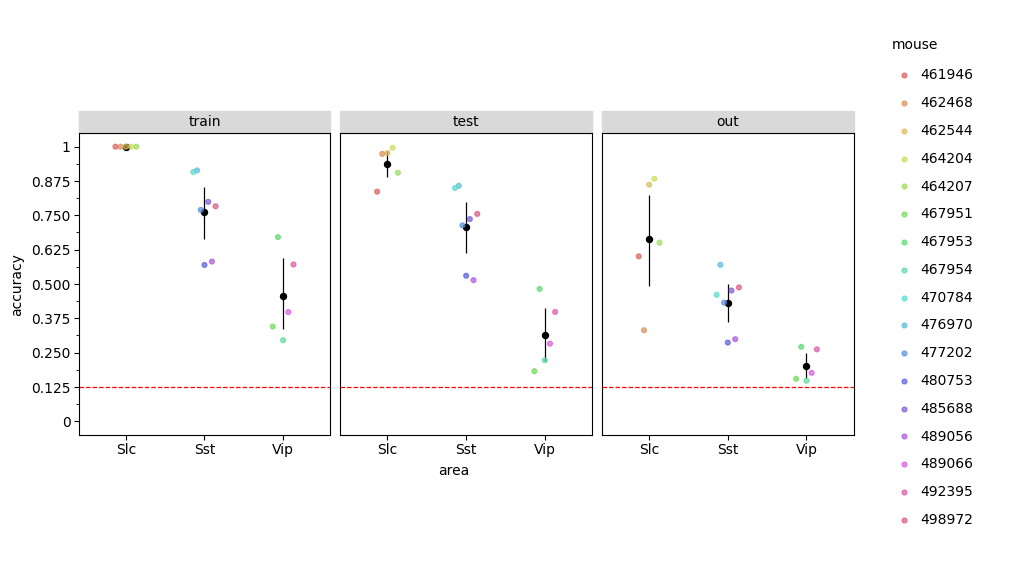

<ggplot: (8731679065349)>


In [ ]:
accuracy_plot(pd.read_pickle('/content/drive/MyDrive/Mouse_Data/accuracy_data_N17_CNN1-25'))

/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  margin_vars = [list(data.columns & self.rows),
/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  list(data.columns & self.cols)]
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/themes/theme.py:250: MatplotlibDeprecationWarning: 
The datapath rcparam was deprecated in Matplotlib 3.2.1 and will be removed two minor

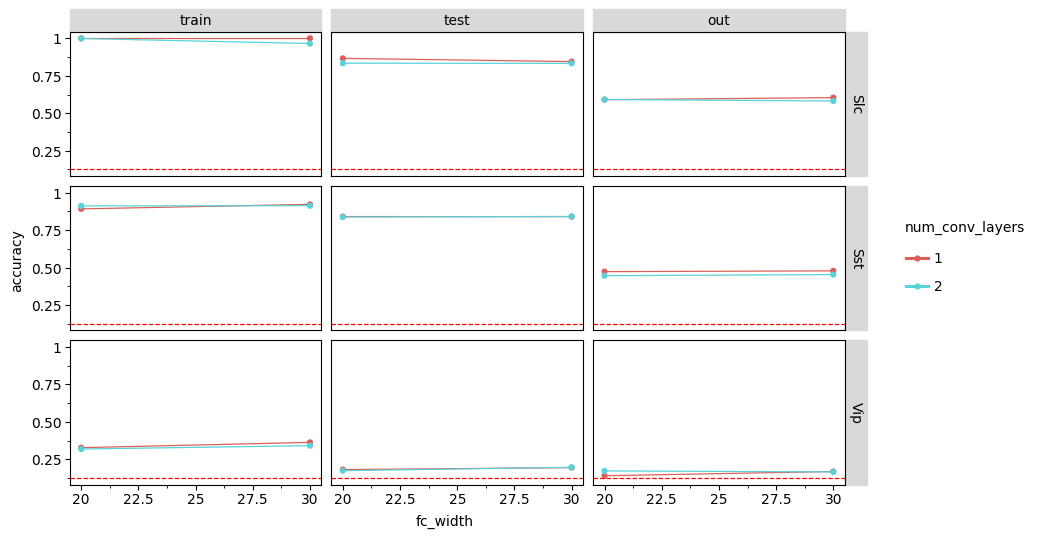

<ggplot: (8792603884201)>


In [ ]:
architecture_plot(pd.read_pickle('/content/drive/MyDrive/Mouse_Data/accuracy_data_N3_CNNarchitectures_2'))

/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  margin_vars = [list(data.columns & self.rows),
/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  list(data.columns & self.cols)]
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/themes/theme.py:250: MatplotlibDeprecationWarning: 
The datapath rcparam was deprecated in Matplotlib 3.2.1 and will be removed two minor

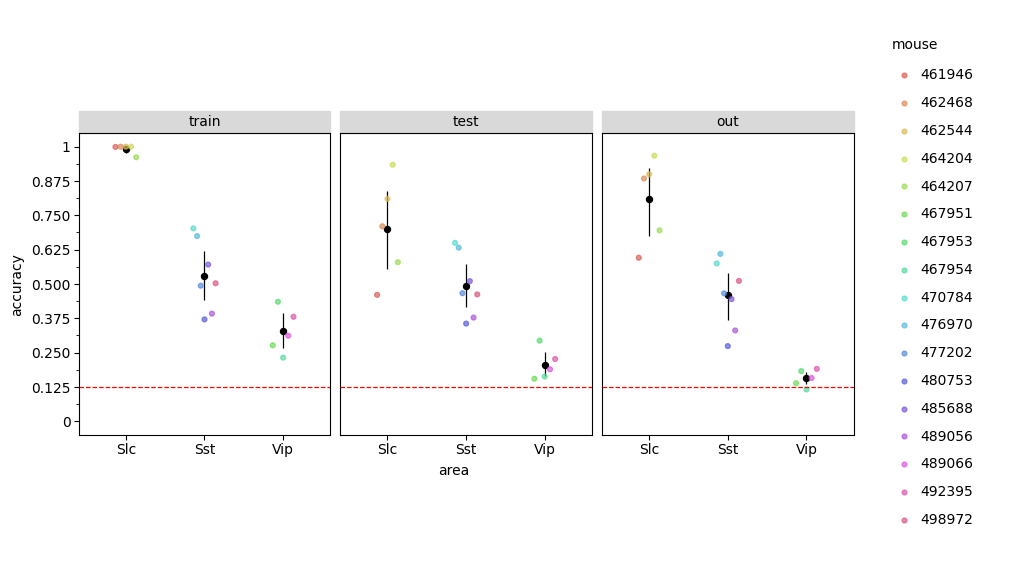

<ggplot: (8770078851733)>


In [ ]:
accuracy_plot(pd.read_pickle('/content/drive/MyDrive/Mouse_Data/accuracy_data_N17_MLPdffbc'))

In [ ]:
# SVM results (not saved, hand-copied from console output, DO NOT MODIFY!)
train_acc = [0.74,0.93,0.93,0.97,0.83,0.67,0.66,0.51,0.38,0.56,0.42,0.52,0.3,0.44,0.26,0.28,0.38]
test_acc = [0.51,0.73,0.81,0.94,0.62,0.64,0.63,0.45,0.35,0.53,0.35,0.46,0.14,0.3,0.19,0.19,0.26]
out_acc = [0.6,0.88,0.87,0.97,0.76,0.6,0.6,0.45,0.27,0.44,0.33,0.51,0.13,0.18,0.12,0.15,0.18]
mouse_id = [461946,462468,462544,464204,464207,470784,476970,477202,480753,485688,489056,498972,467951,467953,467954,489066,492395]
area=['Slc','Slc','Slc','Slc','Slc','Sst','Sst','Sst','Sst','Sst','Sst','Sst','Vip','Vip','Vip','Vip','Vip']
data=['train','test','out']
accuracy_data = pd.DataFrame({'accuracy':np.concatenate([train_acc,test_acc,out_acc]),'data':np.repeat(data,17),'mouse':np.tile(mouse_id,3),'area':np.tile(area,3),'n_cells':1})
#accuracy_data.to_pickle('/content/drive/MyDrive/Mouse_Data/accuracy_data_N17_SVMdffbc.pkl')


/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  margin_vars = [list(data.columns & self.rows),
/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  list(data.columns & self.cols)]
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/themes/theme.py:250: MatplotlibDeprecationWarning: 
The datapath rcparam was deprecated in Matplotlib 3.2.1 and will be removed two minor

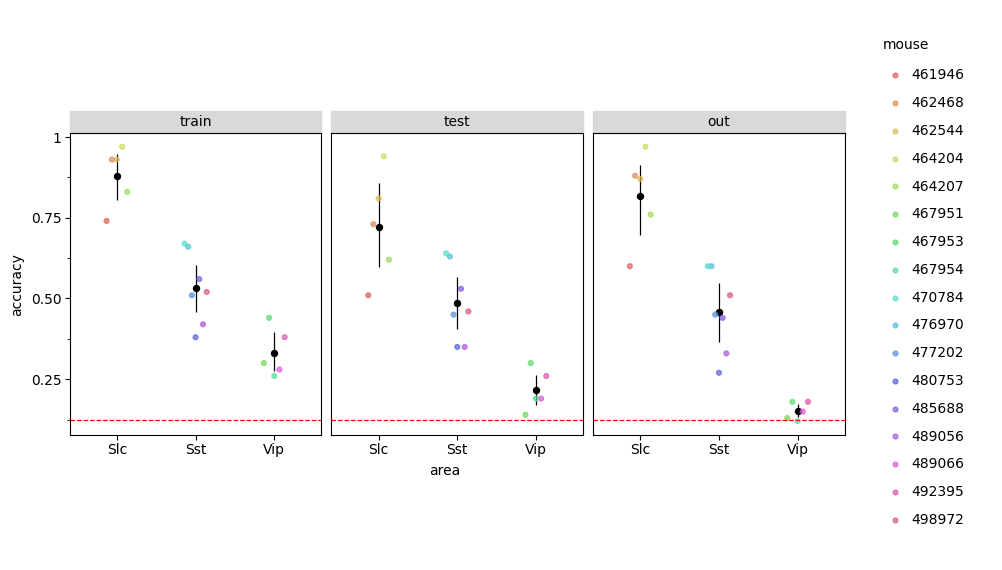

<ggplot: (8764314486597)>


In [ ]:
accuracy_plot(accuracy_data)

/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  margin_vars = [list(data.columns & self.rows),
/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  list(data.columns & self.cols)]
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/themes/theme.py:250: MatplotlibDeprecationWarning: 
The datapath rcparam was deprecated in Matplotlib 3.2.1 and will be removed two minor

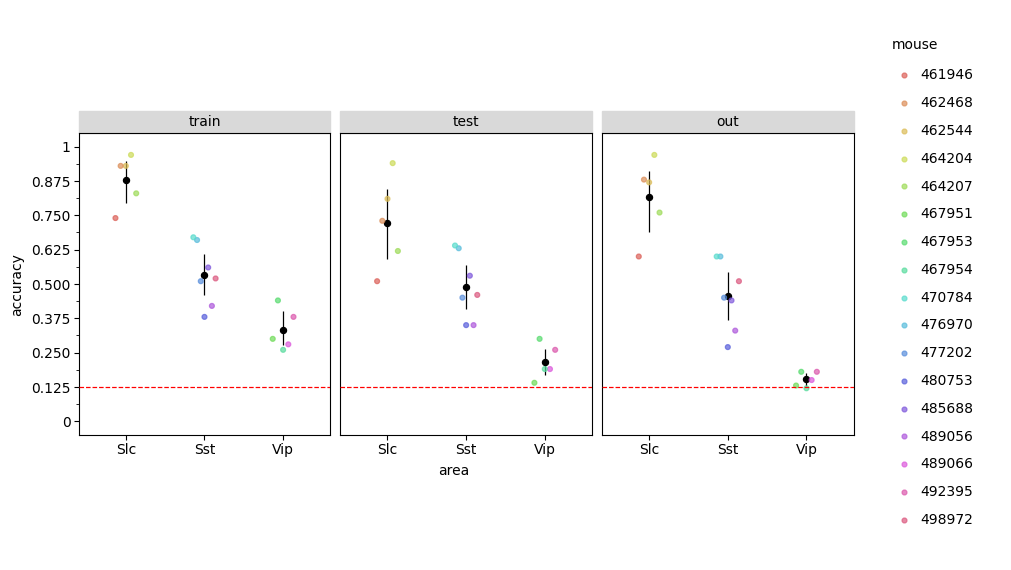

<ggplot: (8770075720305)>


In [ ]:
#accuracy_plot(pd.read_pickle('/content/drive/MyDrive/Mouse_Data/accuracy_data_N17_MLPdffbc'))
accuracy_plot(pd.read_pickle('/content/drive/MyDrive/Mouse_Data/accuracy_data_N17_SVMdffbc.pkl'))

/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  margin_vars = [list(data.columns & self.rows),
/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  list(data.columns & self.cols)]
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/themes/theme.py:250: MatplotlibDeprecationWarning: 
The datapath rcparam was deprecated in Matplotlib 3.2.1 and will be removed two minor

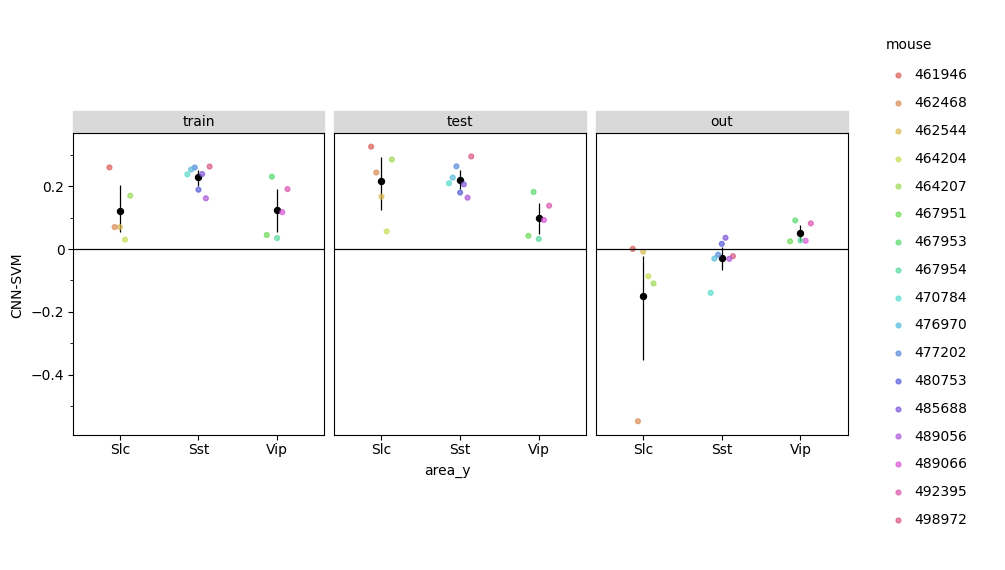

<ggplot: (8731649123565)>

In [ ]:
lol = pd.read_pickle('/content/drive/MyDrive/Mouse_Data/accuracy_data_N17_SVMdffbc.pkl')
lmao = pd.read_pickle('/content/drive/MyDrive/Mouse_Data/accuracy_data_N17_CNN1-25')
lol = lol.merge(lmao,
          how='left',
          on=['mouse','data'],
          )

lol['CNN-SVM'] = lol['accuracy_y']-lol['accuracy_x']
lol = lol.astype({'mouse':'category','data':'category','area_y':'category'})
lol['data'] = pd.Categorical(lol['data'],categories=['train','test','out'])
(p9.ggplot(lol, p9.aes('area_y','CNN-SVM'))
    + p9.scale_x_discrete()
    + p9.facet_grid('. ~ data')
    + p9.stat_summary()
    + p9.geom_point(p9.aes(color='mouse'),position=p9.positions.position_dodge(width=0.33), alpha=0.7)
    + p9.theme_matplotlib()
    + p9.geom_hline(yintercept=0,color='black')
    + p9.theme(figure_size=(10,4))
)

In [ ]:
score_test = {}
score_train = {}
score_out = {}

# Select a mouse
area = 'Slc'
mouse_id = slc_mouse_id[1]

fn = f'{area}_mouse{mouse_id}'
label_data, dff_bc, dff_stim, dff_ts = load_gzip_arrays(fn)

In [ ]:
# Possible subsetting groups
not_omitted = np.logical_not(label_data['omitted'])
familiar = label_data['session_number']<=3
novel = label_data['session_number']>3
passive = np.logical_or(label_data['session_number']==2, label_data['session_number']==5)
active = np.logical_not(passive)
is_change = label_data['is_change']
not_change = np.logical_not(is_change)

# Choose a subset
subset = np.where(np.logical_and.reduce([not_change, not_omitted, familiar]))
subset2 = np.where(np.logical_and.reduce([is_change, not_omitted, familiar]))

len(subset[0])

12966

In [ ]:
# Prepare input data (mean firing rates: dff_bc or dff_stim)
X, y, cell_subset = prepare_data(dff_bc, subset)
X2, y2, = prepare_data(dff_bc, subset2, cell_subset)

In [ ]:
# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, stratify=y)

# Initialize network
net = NetDropout(X_train.shape[1]).to(DEVICE)
optimizer = optim.Adam(net.parameters(), weight_decay=1e-4, lr=1e-2)
criterion = nn.CrossEntropyLoss()
X_train = torch.Tensor(X_train).to(DEVICE)
X_test = torch.Tensor(X_test).to(DEVICE)
y_train = torch.Tensor(y_train).to(torch.int64).to(DEVICE)
y_test = torch.Tensor(y_test).to(torch.int64).to(DEVICE)

In [ ]:
# Train
N_epochs = 500
training_losses = np.empty(N_epochs)
validation_losses = np.empty(N_epochs)
out_losses = np.empty(N_epochs)
training_accs = np.empty(N_epochs)
validation_accs = np.empty(N_epochs)
out_accs = np.empty(N_epochs)

net.train()
for i in tqdm(range(N_epochs)):
  optimizer.zero_grad()
  yhat_val = net(X_test).to(DEVICE)
  loss_val = criterion(yhat_val, y_test)
  yhat_out = net(X2).to(DEVICE)
  loss_out = criterion(yhat_out, y2)
  yhat_train = net(X_train).to(DEVICE)
  loss = criterion(yhat_train, y_train)
  loss.backward()
  optimizer.step()
  training_losses[i] = loss.item()
  validation_losses[i] = loss_val.item()
  out_losses[i] = loss_out.item()

  _, yhat_train_max = torch.max(yhat_train, 1)
  training_accs[i] = (yhat_train_max == y_train).float().sum()/len(yhat_train_max)

  _, yhat_val_max = torch.max(yhat_val, 1)
  validation_accs[i] = (yhat_val_max == y_test).float().sum()/len(yhat_val_max)

  _, yhat_out_max = torch.max(yhat_out, 1)
  out_accs[i] = (yhat_out_max == y2).float().sum()/len(yhat_out_max)

  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 1.0
Test score: 0.9321511179645335
Out score: 0.30963302752293576


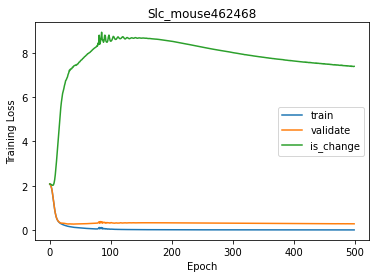

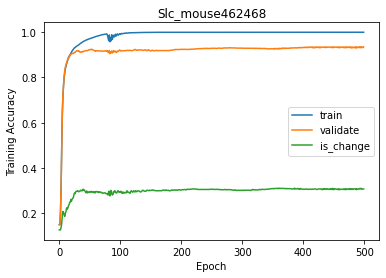

In [ ]:
# Evaluate
net.eval()

plt.figure()
plt.title(fn)
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
# lossdf = pd.DataFrame({'training':training_losses,
#               'validation':validation_losses,
#               'is_change':out_losses})
plt.plot(training_losses,label='train')
plt.plot(validation_losses,label='validate')
plt.plot(out_losses,label='is_change')
plt.legend()

plt.figure()
plt.title(fn)
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
# lossdf = pd.DataFrame({'training':training_losses,
#               'validation':validation_losses,
#               'is_change':out_losses})
plt.plot(training_accs,label='train')
plt.plot(validation_accs,label='validate')
plt.plot(out_accs,label='is_change')
plt.legend()

yhat_train = net(X_train).to('cpu')
_, yhat_train = torch.max(yhat_train, 1)
score_train[mouse_id] = accuracy_score(y_train.to('cpu'), yhat_train)
print(f'Training score: {score_train[mouse_id]}')

yhat_test = net(X_test).to('cpu')
_, yhat_test = torch.max(yhat_test, 1)
score_test[mouse_id] = accuracy_score(y_test.to('cpu'), yhat_test)
print(f'Test score: {score_test[mouse_id]}')

yhat_out = net(X2).to('cpu')
_, yhat_out = torch.max(yhat_out, 1)
score_out[mouse_id] = accuracy_score(y2.to('cpu'), yhat_out)
print(f'Out score: {score_out[mouse_id]}')

In [ ]:
class ConvNetDropout(nn.Module):
  """
  """

  def __init__(self,input_feature_num):
    super(ConvNetDropout, self).__init__()
    filters_num = 1
    self.conv = nn.Conv1d(input_feature_num,filters_num*input_feature_num,kernel_size=5,padding=2,stride=1)
    #self.pool = nn.AdaptiveAvgPool1d(1)
    self.fc1 = nn.Linear(filters_num*input_feature_num, 100)
    self.fc2 = nn.Linear(100, 100)
    self.fc3 = nn.Linear(100, 8)

  def forward(self, x):
    x0 = self.conv(x)
    #x1 = torch.squeeze(self.pool(x0))
    x1 = torch.amax(x0,2)
    x2 = F.leaky_relu(self.fc1(x1))
    x3 = F.leaky_relu(self.fc2(x2))
    output = self.fc3(x3)
    return output

In [ ]:
# Prepare input data (time series firing rates)
X, y, cell_subset = prepare_data(dff_ts, subset)
X2, y2, _ = prepare_data(dff_ts, subset2, cell_subset)

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, stratify=y)

X_train = torch.Tensor(X_train).to(DEVICE)
X_test = torch.Tensor(X_test).to(DEVICE)
y_train = torch.Tensor(y_train).to(torch.int64).to(DEVICE)
y_test = torch.Tensor(y_test).to(torch.int64).to(DEVICE)

# Initialize
net = ConvNetDropout(X_train.shape[1]).to(DEVICE)
optimizer = optim.Adam(net.parameters(), weight_decay=1e-4, lr=1e-2)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Train
N_epochs = 500
training_losses = np.empty(N_epochs)
validation_losses = np.empty(N_epochs)
out_losses = np.empty(N_epochs)
training_accs = np.empty(N_epochs)
validation_accs = np.empty(N_epochs)
out_accs = np.empty(N_epochs)
net.train()
for i in tqdm(range(N_epochs)):
  optimizer.zero_grad()
  yhat_val = net(X_test)
  yhat_val = yhat_val.to(DEVICE)
  loss_val = criterion(yhat_val, y_test)
  yhat_out = net(X2).to(DEVICE)
  loss_out = criterion(yhat_out, y2)
  yhat_train = net(X_train).to(DEVICE)
  loss = criterion(yhat_train, y_train)
  loss.backward()
  optimizer.step()
  training_losses[i] = loss.item()
  validation_losses[i] = loss_val.item()
  out_losses[i] = loss_out.item()

  _, yhat_train_max = torch.max(yhat_train, 1)
  training_accs[i] = (yhat_train_max == y_train).float().sum()/len(yhat_train_max)

  _, yhat_val_max = torch.max(yhat_val, 1)
  validation_accs[i] = (yhat_val_max == y_test).float().sum()/len(yhat_val_max)

  _, yhat_out_max = torch.max(yhat_out, 1)
  out_accs[i] = (yhat_out_max == y2).float().sum()/len(yhat_out_max)

  # _, yhat_train = torch.max(yhat_train, 1)
  # score_train[mouse_id] = accuracy_score(y_train.to('cpu'), yhat_train)

Training score: 0.5272573124205172
Test score: 0.17543859649122806
Out score: 0.14112903225806453


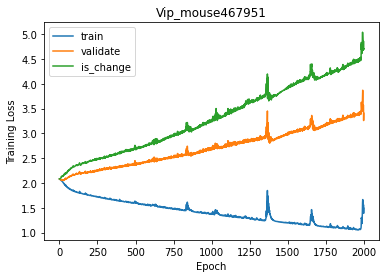

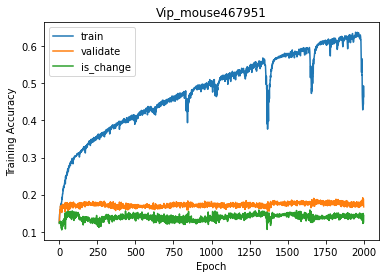

In [ ]:
# Evaluate
net.eval()

plt.figure()
plt.title(fn)
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
plt.plot(training_losses,label='train')
plt.plot(validation_losses,label='validate')
plt.plot(out_losses,label='is_change')
plt.legend()

plt.figure()
plt.title(fn)
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
plt.plot(training_accs,label='train')
plt.plot(validation_accs,label='validate')
plt.plot(out_accs,label='is_change')
plt.legend()

yhat_train = net(X_train).to('cpu')
_, yhat_train = torch.max(yhat_train, 1)
score_train[mouse_id] = accuracy_score(y_train.to('cpu'), yhat_train)
print(f'Training score: {score_train[mouse_id]}')

yhat_test = net(X_test).to('cpu')
_, yhat_test = torch.max(yhat_test, 1)
score_test[mouse_id] = accuracy_score(y_test.to('cpu'), yhat_test)
print(f'Test score: {score_test[mouse_id]}')

yhat_out = net(X2).to('cpu')
_, yhat_out = torch.max(yhat_out, 1)
score_out[mouse_id] = accuracy_score(y2.to('cpu'), yhat_out)
print(f'Out score: {score_out[mouse_id]}')